In [90]:
import pandas as pd
import gpxpy
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import contextily as ctx

In [75]:
def parse_gpx_file(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                data.append({
                    'time': point.time,
                    'latitude': point.latitude, 
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                })

    df = pd.DataFrame(data)

    df['prev_latitude'] = df['latitude'].shift(1)
    df['prev_longitude'] = df['longitude'].shift(1)

    df = df.dropna().reset_index(drop=True)

    df['distance'] = df.apply(lambda x: geodesic((x['prev_latitude'], x['prev_longitude']), (x['latitude'], x['longitude'])).meters, axis=1)
    df['accumulated_distance'] = df['distance'].cumsum()
    
    df['time_diff'] = df['time'].diff()
    
    df['time'] = df['time'].dt.tz_localize(None)
    
    return df

In [76]:
garmin_df = parse_gpx_file('../data/Garmin Etrex.gpx')
polar_df = parse_gpx_file('../data/Polar Vantage V.gpx')

In [77]:
garmin_df.head(3)

,time,latitude,longitude,elevation,prev_latitude,prev_longitude,distance,accumulated_distance,time_diff
0,2024-05-12 22:36:54,1.309668,103.896096,18.400024,1.309669,103.896214,13.032151,13.032151,NaT
1,2024-05-12 22:37:01,1.309664,103.895943,19.799988,1.309668,103.896096,17.067700,30.099851,0 days 00:00:07
2,2024-05-12 22:37:08,1.309687,103.895766,16.200012,1.309664,103.895943,19.873921,49.973771,0 days 00:00:07


In [78]:
polar_df.head(3)

,time,latitude,longitude,elevation,prev_latitude,prev_longitude,distance,accumulated_distance,time_diff
0,2024-05-12 22:36:57.038,1.309210,103.895885,0.0,1.309172,103.895878,4.302848,4.302848,NaT
1,2024-05-12 22:36:58.038,1.309242,103.895888,0.0,1.309210,103.895885,3.521461,7.824309,0 days 00:00:01
2,2024-05-12 22:36:59.038,1.309285,103.895903,0.0,1.309242,103.895888,5.073701,12.898009,0 days 00:00:01


In [79]:
# Make sure the dates are aligned
polar_df = polar_df[polar_df['time'] > garmin_df.loc[0, 'time']]
garmin_df = garmin_df[garmin_df['time'] < polar_df['time'].iloc[-1]]

In [47]:
garmin_df.iloc[0][0], garmin_df.iloc[-1][0]

(Timestamp('2024-05-12 22:36:54+0000', tz='SimpleTZ("Z")'),
 Timestamp('2024-05-12 23:26:32+0000', tz='SimpleTZ("Z")'))

In [48]:
polar_df.iloc[0][0], polar_df.iloc[-1][0]

(Timestamp('2024-05-12 22:36:57.038000+0000', tz='SimpleTZ("Z")'),
 Timestamp('2024-05-12 23:26:34.037000+0000', tz='SimpleTZ("Z")'))

In [49]:
print(polar_df['accumulated_distance'].iloc[-1], garmin_df['accumulated_distance'].iloc[-1])

7934.405225143684 7747.349379654002


In [50]:
print(polar_df.shape[0], garmin_df.shape[0])

2947 656


In [52]:
print(polar_df['time_diff'].mean().total_seconds(), garmin_df['time_diff'].mean().total_seconds())

1.010522 4.546564


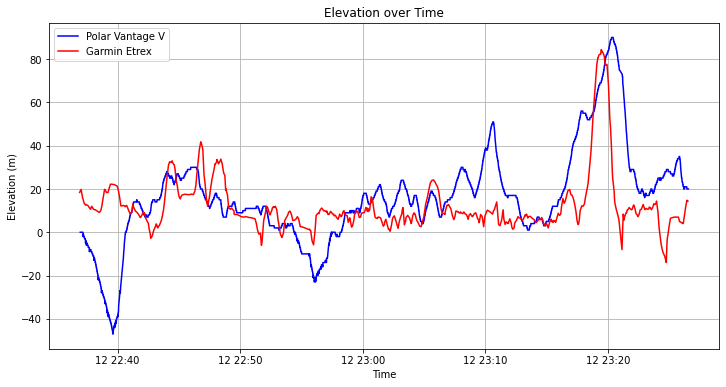

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['elevation'], color='blue', label='Polar Vantage V')
plt.plot(garmin_df['time'], garmin_df['elevation'], color='red', label='Garmin Etrex')
plt.xlabel('Time')
plt.ylabel('Elevation (m)')
plt.title('Elevation over Time')
plt.legend()
plt.grid(True)
plt.show()    

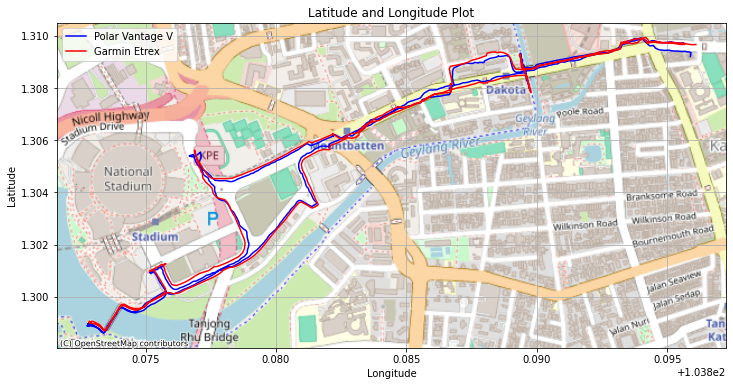

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['longitude'], polar_df['latitude'], color='blue', linestyle='-', label='Polar Vantage V')
plt.plot(garmin_df['longitude'], garmin_df['latitude'], color='red', linestyle='-', label='Garmin Etrex')
ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude and Longitude Plot')
plt.legend()
plt.grid(True)
plt.show()